In [ ]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers"""

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import os
from typing import List, Union

## 1.) Read CSV file

 This function is designed to handle the challenge of reading CSV files with Thai text.

In [ ]:
#Thai encodings
'''Data is in csv file which has two columns: ‘text’, ‘label’(0 : non-scam,1:scam)'''

def load_thai_csv(file_path):
    encodings = ['tis-620', 'cp874', 'utf-8-sig', 'utf-16']

    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            print(f"Successfully read file with {encoding} encoding")
            # Verify if the text is readable
            print("\nFirst few rows of text:")
            print(df['text'].head())
            user_input = input("\nIs the text readable? (y/n): ")
            if user_input.lower() == 'y':
                return df
        except Exception as e:
            print(f"Failed with {encoding} encoding: {str(e)}")
            continue

    raise Exception("Could not read file with any of the attempted encodings")

## 2.) Construct the model

In [ ]:
class ThaiSMSClassifier(nn.Module):
    def __init__(self, pretrained_model_name="openthaigpt/openthaigpt1.5-7b-instruct"):
        super().__init__()

        # Load pretrained model
        self.gpt = AutoModelForCausalLM.from_pretrained(pretrained_model_name)

        # Freeze all parameters of the pretrained model
        for param in self.gpt.parameters():
            param.requires_grad = False

        # classification head
        self.classifier = nn.Sequential(
            # First layer: 512 neurons,then 256
            nn.Linear(self.gpt.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            # Output layer: 2 classes
            nn.Linear(256, 2),
            nn.Softmax(dim=1)  # Keep softmax for BCE
        )

    def forward(self, input_ids, attention_mask):
        # 1. Pass through GPT model
        outputs = self.gpt(input_ids=input_ids,
                          attention_mask=attention_mask,
                          output_hidden_states=True)

        # 2. Get last hidden layer output
        last_hidden_state = outputs.hidden_states[-1]

        # 3. Extract CLS token representation
        cls_hidden_state = last_hidden_state[:, 0, :]

        # 4. Classification
        logits = self.classifier(cls_hidden_state)
        return logits # Return class scores

## 3.) Tokenization Process

In [ ]:
# Dataset class
class SMSDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts,
                                 truncation=True,
                                 padding='max_length',
                                 max_length=max_length,
                                 return_tensors='pt')
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

## 4.) Early Stopping

In [ ]:

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## 5.) Plot Learning Curve

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean().item()




## 6.) Train Model

In [ ]:

def train_model(model, train_loader, val_loader, device, num_epochs=10):
    model = model.to(device)
    # Use BCE loss
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=3)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        train_steps = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Convert labels to one-hot encoding
            labels_one_hot = torch.zeros(labels.size(0), 2, device=device)
            labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Calculate BCE loss
            loss = criterion(outputs, labels_one_hot)

            # Calculate accuracy
            preds = torch.argmax(outputs, dim=1)
            accuracy = (preds == labels).float().mean().item()

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += accuracy
            train_steps += 1

        avg_train_loss = total_train_loss / train_steps
        avg_train_acc = total_train_acc / train_steps

        # Validation
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        val_steps = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Convert labels to one-hot encoding
                labels_one_hot = torch.zeros(labels.size(0), 2, device=device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels_one_hot)

                preds = torch.argmax(outputs, dim=1)
                accuracy = (preds == labels).float().mean().item()

                total_val_loss += loss.item()
                total_val_acc += accuracy
                val_steps += 1

        avg_val_loss = total_val_loss / val_steps
        avg_val_acc = total_val_acc / val_steps

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_acc)
        val_accuracies.append(avg_val_acc)

        print(f'Epoch {epoch + 1}:')
        print(f'Average training loss: {avg_train_loss:.4f}, accuracy: {avg_train_acc:.4f}')
        print(f'Average validation loss: {avg_val_loss:.4f}, accuracy: {avg_val_acc:.4f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

    # Load best model
    model.load_state_dict(best_model_state)
    return model

## 7.) Evaluation

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-scam', 'Scam']))

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-scam', 'Scam'],
                yticklabels=['Non-scam', 'Scam'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

## 8.) Save Model

In [ ]:
#Save Model
def save_model(model: ThaiSMSClassifier, tokenizer: AutoTokenizer, save_dir: str = '/content/drive/MyDrive/DADS_NLP/Final_Project/save_model') -> None:
    """
    Save the trained model and tokenizer to disk.

    Args:
        model: Trained ThaiSMSClassifier model
        tokenizer: The tokenizer used with the model
        save_dir: Directory to save the model and tokenizer
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save model state dict
    torch.save(model.state_dict(), os.path.join(save_dir, 'model_state.pt'))

    # Save tokenizer
    tokenizer.save_pretrained(save_dir)

    print(f"Model and tokenizer saved to {save_dir}")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

Successfully read file with tis-620 encoding

First few rows of text:
0                                    สินเชื่อ ปล่อยกู้
1    เพราะคุณคือคนพิเศษ!ลุ้นรับบัตรเติมเงินฟรี กด*1...
2    เกมออนไลน์ ลุ้นรับ10,000\n เติม-ถอน AUTOเร็ว10...
3    มูลนิธิสมเด็จพระญาณสังวรฯ ขอเชิญร่วมสมทบทุนเพื...
4    คุณสามารถกู้ 90,000 บาทจากธนาคารไทย คลิ๊ก:http...
Name: text, dtype: object

Is the text readable? (y/n): y


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.20s/it]


Epoch 1:
Average training loss: 0.8021, accuracy: 0.6313
Average validation loss: 0.6976, accuracy: 0.7098


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.20s/it]


Epoch 2:
Average training loss: 0.5441, accuracy: 0.7328
Average validation loss: 0.6088, accuracy: 0.7098


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.20s/it]


Epoch 3:
Average training loss: 0.4517, accuracy: 0.8069
Average validation loss: 0.7619, accuracy: 0.5893


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.20s/it]


Epoch 4:
Average training loss: 0.4372, accuracy: 0.7933
Average validation loss: 0.6961, accuracy: 0.7902


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.20s/it]


Epoch 5:
Average training loss: 0.3979, accuracy: 0.8115
Average validation loss: 0.7469, accuracy: 0.7277
Early stopping triggered


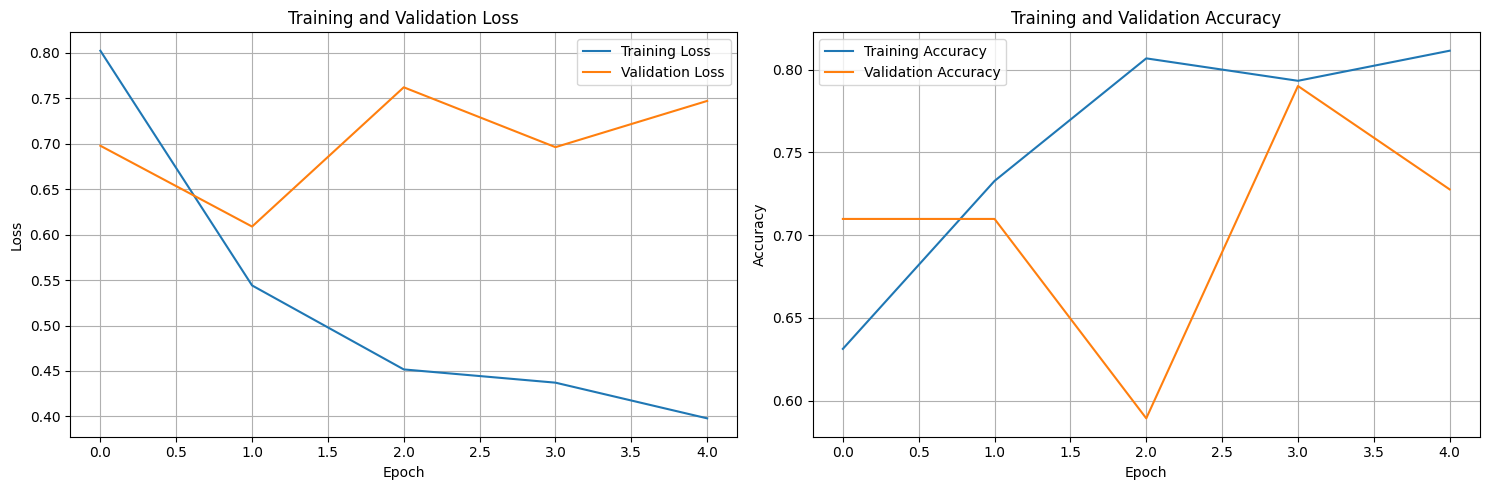

Evaluating: 100%|██████████| 8/8 [00:49<00:00,  6.14s/it]



Classification Report:
              precision    recall  f1-score   support

    Non-scam       0.72      0.71      0.72        62
        Scam       0.71      0.72      0.72        61

    accuracy                           0.72       123
   macro avg       0.72      0.72      0.72       123
weighted avg       0.72      0.72      0.72       123

Model and tokenizer saved to /content/drive/MyDrive/DADS_NLP/Final_Project/save_model


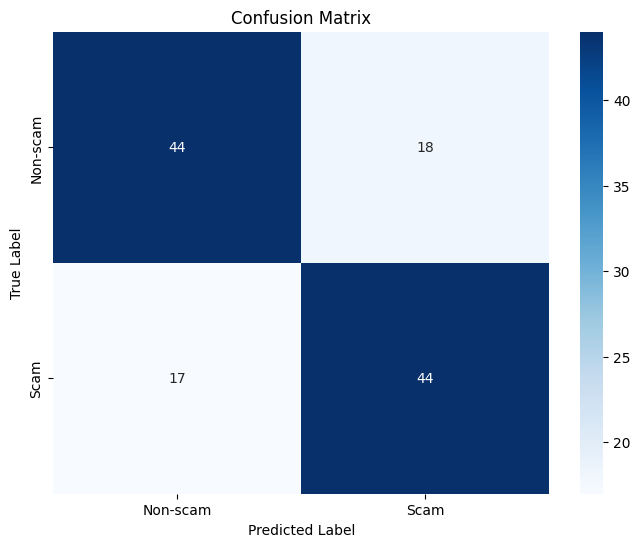

In [ ]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Initialize tokenizer and model
    model_name = "openthaigpt/openthaigpt1.5-7b-instruct"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = ThaiSMSClassifier(model_name)

    # Read and prepare data with proper Thai encoding
    try:
        df = load_thai_csv('/content/drive/MyDrive/DADS_NLP/Final_Project/SMS Dataset.csv')
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return

    # Data splitting
    temp_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    train_df, val_df = train_test_split(temp_df, test_size=0.125, random_state=42, stratify=temp_df['label'])

    # Create datasets
    train_dataset = SMSDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
    val_dataset = SMSDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer)
    test_dataset = SMSDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Train model
    model = train_model(model, train_loader, val_loader, device)

    # Evaluate model
    evaluate_model(model, test_loader, device)

    #Save Model
    save_model(model, tokenizer)


if __name__ == "__main__":
    main()


## 9.) Inference

In [ ]:
def load_saved_model(save_dir: str = '/content/drive/MyDrive/DADS_NLP/Final_Project/save_model', device: str = None) -> tuple:
    """
    Load the saved model and tokenizer.

    Args:
        save_dir: Directory containing the saved model and tokenizer
        device: Device to load the model on ('cuda' or 'cpu')

    Returns:
        tuple: (loaded_model, loaded_tokenizer)
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(save_dir)

    # Initialize model
    model = ThaiSMSClassifier("openthaigpt/openthaigpt1.5-7b-instruct")

    # Load state dict
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model_state.pt'),
                                   map_location=torch.device(device)))

    model = model.to(device)
    model.eval()

    return model, tokenizer

In [ ]:
def predict_text(model: ThaiSMSClassifier,
                tokenizer: AutoTokenizer,
                texts: Union[str, List[str]],
                device: str = None) -> List[dict]:
    """
    Make predictions on new text data.

    Args:
        model: Loaded ThaiSMSClassifier model
        tokenizer: The tokenizer
        texts: Single text string or list of texts to predict
        device: Device to run prediction on

    Returns:
        list: List of dictionaries containing predictions and probabilities
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Convert single text to list
    if isinstance(texts, str):
        texts = [texts]

    # Prepare dataset
    dataset = SMSDataset(texts, [0] * len(texts), tokenizer)  # Dummy labels
    dataloader = DataLoader(dataset, batch_size=16)

    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = outputs.cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            for pred, prob in zip(preds, probs):
                predictions.append({
                    'prediction': 'Scam' if pred == 1 else 'Non-scam',
                    'confidence': float(prob[pred]),
                    'probabilities': {
                        'Non-scam': float(prob[0]),
                        'Scam': float(prob[1])
                    }
                })

    return predictions

In [ ]:
# Load the saved model and tokenizer
model_path = '/content/drive/MyDrive/DADS_NLP/Final_Project/save_model'  # Replace with your saved model path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and tokenizer
model, tokenizer = load_saved_model(model_path, device)
print("Model and tokenizer loaded successfully")

# Example 1: Predict single text
text = "ยินดีด้วยคุณได้รับรางวัลจากธนาคาร กรุณาโอนค่าธรรมเนียม 1,000 บาท"
result = predict_text(model, tokenizer, text, device)
print("\nSingle Text Prediction:")
print(f"Text: {text}")
print(f"Prediction: {result[0]['prediction']}")
print(f"Confidence: {result[0]['confidence']:.2%}")
print("Class Probabilities:", result[0]['probabilities'])

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-9-c9cbe99c36e4>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_dir, 'model_state.pt'),


Model and tokenizer loaded successfully

Single Text Prediction:
Text: ยินดีด้วยคุณได้รับรางวัลจากธนาคาร กรุณาโอนค่าธรรมเนียม 1,000 บาท
Prediction: Scam
Confidence: 94.22%
Class Probabilities: {'Non-scam': 0.057820286601781845, 'Scam': 0.9421797394752502}
